In [1]:
import glob
import random
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import v2

# Traditional Features Construction

In [2]:
def get_image():
    path = "../DataSet/Training/Normal"
    folders = os.listdir(path)
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"{path}/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"{path}/{folder}")
        collection[folder] = all_files
        
    return collection

In [3]:
image_collections = get_image()

In [4]:
def feature_extraction(path, new_path, folder, image):
    path = path + "/" + folder + "/" + image
    loaded_image = cv.imread(path)
    
    gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv.drawKeypoints(gray, kp, loaded_image)
    
    new_path = new_path + "/" + folder
    if not os.path.exists(new_path):
        os.mkdir(new_path)
    new_path = new_path + "/" + image
    cv.imwrite(new_path, img)

In [5]:
def get_features():
    path = "../DataSet/Training/Normal"
    new_path = "../DataSet/Training/Feature Constructed"
    folders = []
    if not os.path.exists(path):
        os.mkdir(path)
    for folder, images in image_collections.items():
        for image in images:
            folders.append(folder)
            feature_extraction(path, new_path, folder, image)
    
    return folders

In [6]:
folders = get_features()

In [7]:
def get_dataset():
    training_images = glob.glob("../DataSet/Training/Feature Constructed/*/*")
    testing_images = glob.glob("../DataSet/Testing/*/*")
        
    return training_images, testing_images

In [8]:
training_img, testing_img = get_dataset()

In [11]:
def dataset_target(images):
    targets = {f: 0 for f in folders}  
    for i, a in enumerate(images):
        b = a.split("\\")
        targets[b[1]] += 1
    
    target_images = []
    for i, (k, v) in enumerate(targets.items()):
        target_images = np.concatenate((target_images, np.full(v, i)), axis = 0) 
        
    return target_images

In [12]:
training_images_target = dataset_target(training_img)
testing_images_target = dataset_target(testing_img)

In [13]:
def plot_img_keypoints(img):    
    img = plt.imread(img)
    plt.imshow(img)

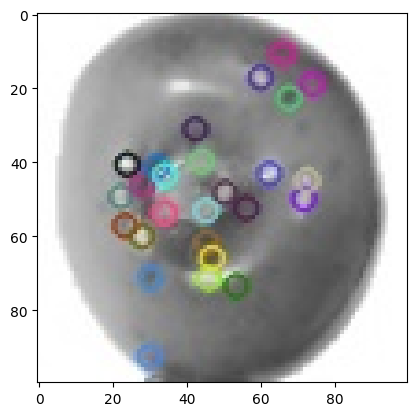

In [14]:
random_image = random.choices(training_img)
plot_img_keypoints(random_image[0])

In [15]:
def create_new_keypoints(image_set=training_img):
    keypoints = []
    
    for image in image_set:
        loaded_image = cv.imread(image)
        gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        
        keypoints.extend(kp)
    
    keypoints = np.array([kp.pt for kp in keypoints])
    
    return keypoints

In [16]:
training_img_keypoints = create_new_keypoints()

In [47]:
def get_pixels(images):
    combine = []
    for img in images:
        loaded_image = cv.imread(img)
        combine.append(loaded_image)
    
    return np.array(combine)

In [48]:
training_images = get_pixels(training_img)
testing_images = get_pixels(testing_img)

In [17]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=100, random_state=0, init="random", n_init="auto").fit(X)    
    return kmeans

In [18]:
def plot_clusters(X):
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()

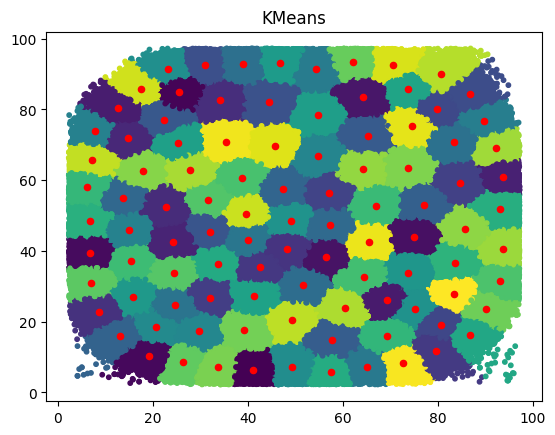

In [19]:
kmeans = k_means_clustering(training_img_keypoints)
plot_clusters(training_img_keypoints)

In [57]:
def k_means_learned_vector_images():
    image_vectors = kmeans.transform(training_img_keypoints)
    return image_vectors

In [58]:
def training_images_vector_images():
    image_vectors = kmeans.transform(training_images)
    return image_vectors

In [59]:
# a = training_images_vector_images()

# Note: You should not use the class labels ???

In [61]:
def dimension_reduction(features):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(features)
    
    for i in range(4):
        c = np.flatnonzero(class_labels == i)
        plt.scatter(transformed_data[c, 0], transformed_data[c, 1])
    plt.show()
    
#     return transformed_data

In [63]:
image_vectors = k_means_learned_vector_images()
dimension_reduction(image_vectors)

NameError: name 'class_labels' is not defined

# Traditional Machine Learnign model - Support Vecotr Machine (SVM)

In [21]:
def train_svm(kernel_type="linear"):
    num_samples, height, width, channels = np.array(training_images).shape
    X_train = np.array(training_images).reshape(num_samples, height * width * channels)
    
    num_samples, height, width, channels = np.array(testing_images).shape
    X_test = np.array(testing_images).reshape(num_samples, height * width * channels) 
    
    scores = []
    parameters = [0.001, 0.1, 1.0, 10, 100]
    for c in parameters:
        svc = SVC(kernel=kernel_type, C=c, random_state=42)
        svc.fit(X_train, training_images_target)
        scores.append(1 - svc.score(X_test, testing_images_target))
    
    return scores

In [ ]:
scores = train_svm()

In [ ]:
def plot_svm_performance():
    plt.plot()

In [ ]:
def train_svm_for_different_kernels():
    kernel_type = "rbf", "poly", "sigmoid"
    for kernel in kernel_type:
        train_svm(kernel_type)

# Deep Learning - Training a Simple Convolution Neural Network Mode

In [ ]:
def images_classifier():
    num_nodes = 10
    input_shape = (100, 100, 1)
    
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"), 
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"), 
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(), 
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(num_nodes, activation="softmax")
    ])
    
    model.summary()
    
    return model

In [ ]:
model = images_classifier()

In [ ]:
def train_model():
    batch_size = 128
    num_epochs = 30
    
    X_train = np.array(training_images)
    y_train = np.array(training_images_target)
    X_test = np.array(testing_images)
    y_test = np.array(testing_images_target)
    
    print(X_train.shape, X_test.shape)
    X_train = X_train.astype("float32") / 255
    X_test = X_test.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)
    print("x_train shape:", X_train.shape)
    print(X_train.shape[0], "train samples")
    print(X_test.shape[0], "test samples")
    
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    
train_model()

In [ ]:
def model_evaluation():
    model, history, X_test, y_test = train_model()
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\n\nTest loss:", score[0])
    print("Test accuracy:", score[1])
    
    return history

In [ ]:
model = model_evaluation()

# Transfer Learning via Feature Extraction

In [ ]:
def preprocessing_read():
    data_transforms = v2.Compose([
        v2.Resize((224,224)),   
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])

    test_classes = []
    for image in testing_images:
        transformed_images = data_transforms(image)
        test_classes.append(transformed_images)
    
    return test_classes

In [ ]:
test_classes = preprocessing_read()

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

In [ ]:
accuracy = alexnet(test_classes)    
accuracy